In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mpl_finance

In [ ]:
!pip install ta

In [5]:
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import mpl_finance as mpf
import numpy as np
import pandas as pd
from matplotlib.pylab import date2num

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MMTC/Сбербанк.txt', sep=';', parse_dates= ["<DATE>"])[["<DATE>","<OPEN>",'<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df['<DATE_1>'] =df['<DATE>'].apply(lambda x:date2num(x))

Text(0.5, 0, 'time')

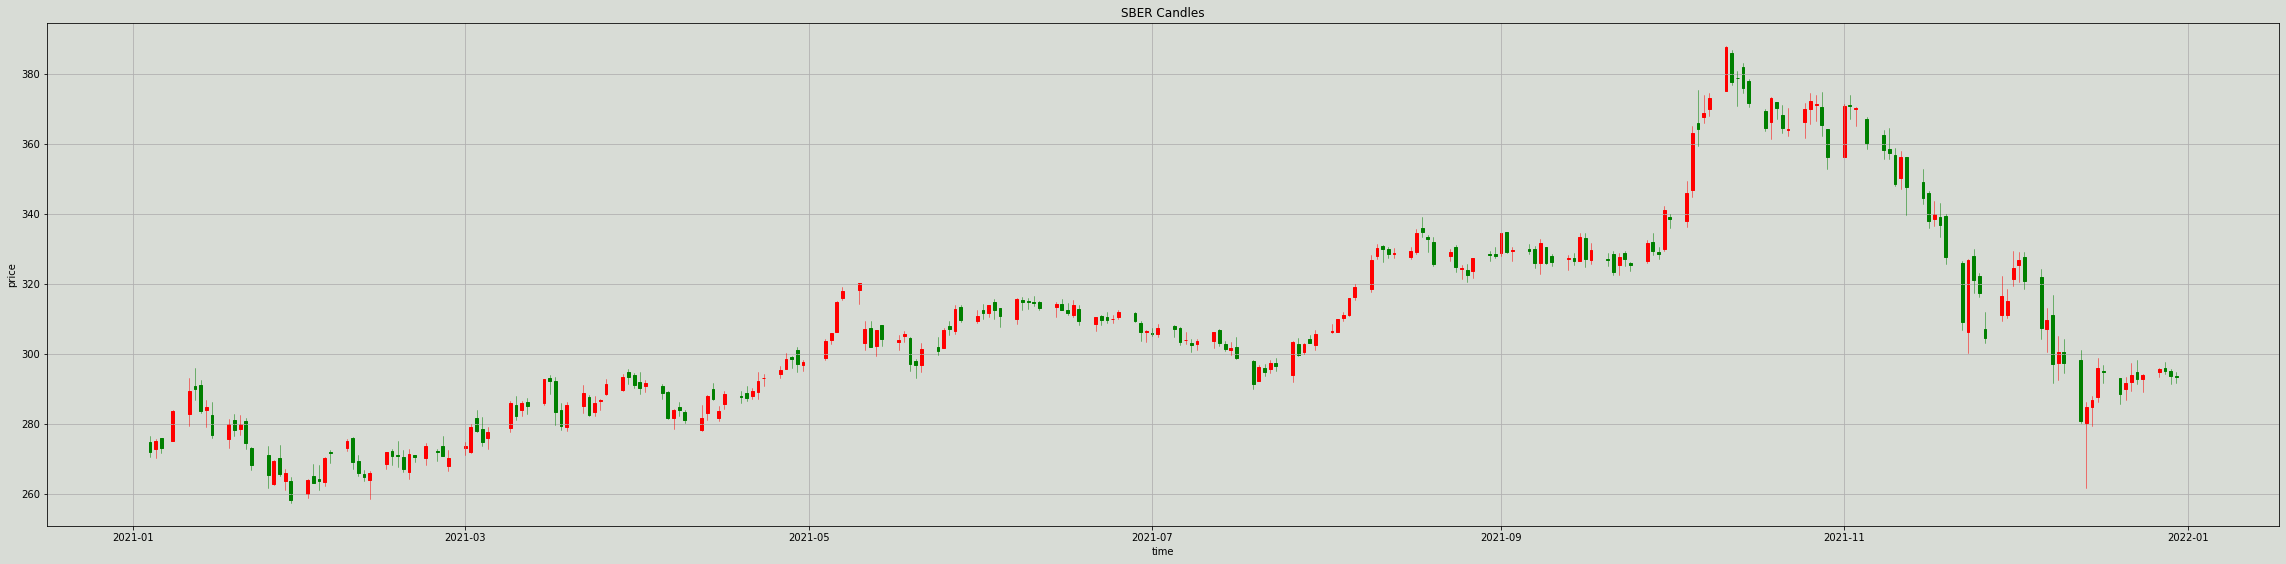

In [8]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

candlestick_ohlc(ax,np.array(df[["<DATE_1>",	"<OPEN>",	"<HIGH>",	"<LOW>",	"<CLOSE>"]]),width=0.5,colorup='r',colordown='green') 

ax.set_title('SBER Candles')
ax.xaxis_date()
ax.set_ylabel('price')
ax.grid(True)
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('time')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   <DATE>    255 non-null    datetime64[ns]
 1   <OPEN>    255 non-null    float64       
 2   <HIGH>    255 non-null    float64       
 3   <LOW>     255 non-null    float64       
 4   <CLOSE>   255 non-null    float64       
 5   <VOL>     255 non-null    int64         
 6   <DATE_1>  255 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.1 KB


In [10]:
df["<VOL>"] = pd.to_numeric(df["<VOL>"], errors='coerce')
df["<VOL>"] = df["<VOL>"].fillna(0)

In [11]:
from ta import add_all_ta_features
import ta
df = add_all_ta_features(df, open="<OPEN>", high="<HIGH>", low="<LOW>", close="<CLOSE>", volume="<VOL>", fillna=True)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


# Полосы Боллинджера (Bollinger Bands) и MACD


In [12]:
from ta.volatility import BollingerBands
indicator_bb = BollingerBands(close=df["<CLOSE>"], window=20, window_dev = 2)
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

In [13]:
from ta.trend import MACD
MACD = MACD(df["<CLOSE>"], window_fast = 11, window_slow = 27, window_sign = 9)
df["MACD"] = MACD.macd()
df["MACD_signal"] = MACD.macd_signal()
df["MACD_gist"] = MACD.macd_diff()

In [14]:
from ta.trend import SMAIndicator
df["SMA"] = SMAIndicator(close=df["<CLOSE>"], window = 2).sma_indicator()

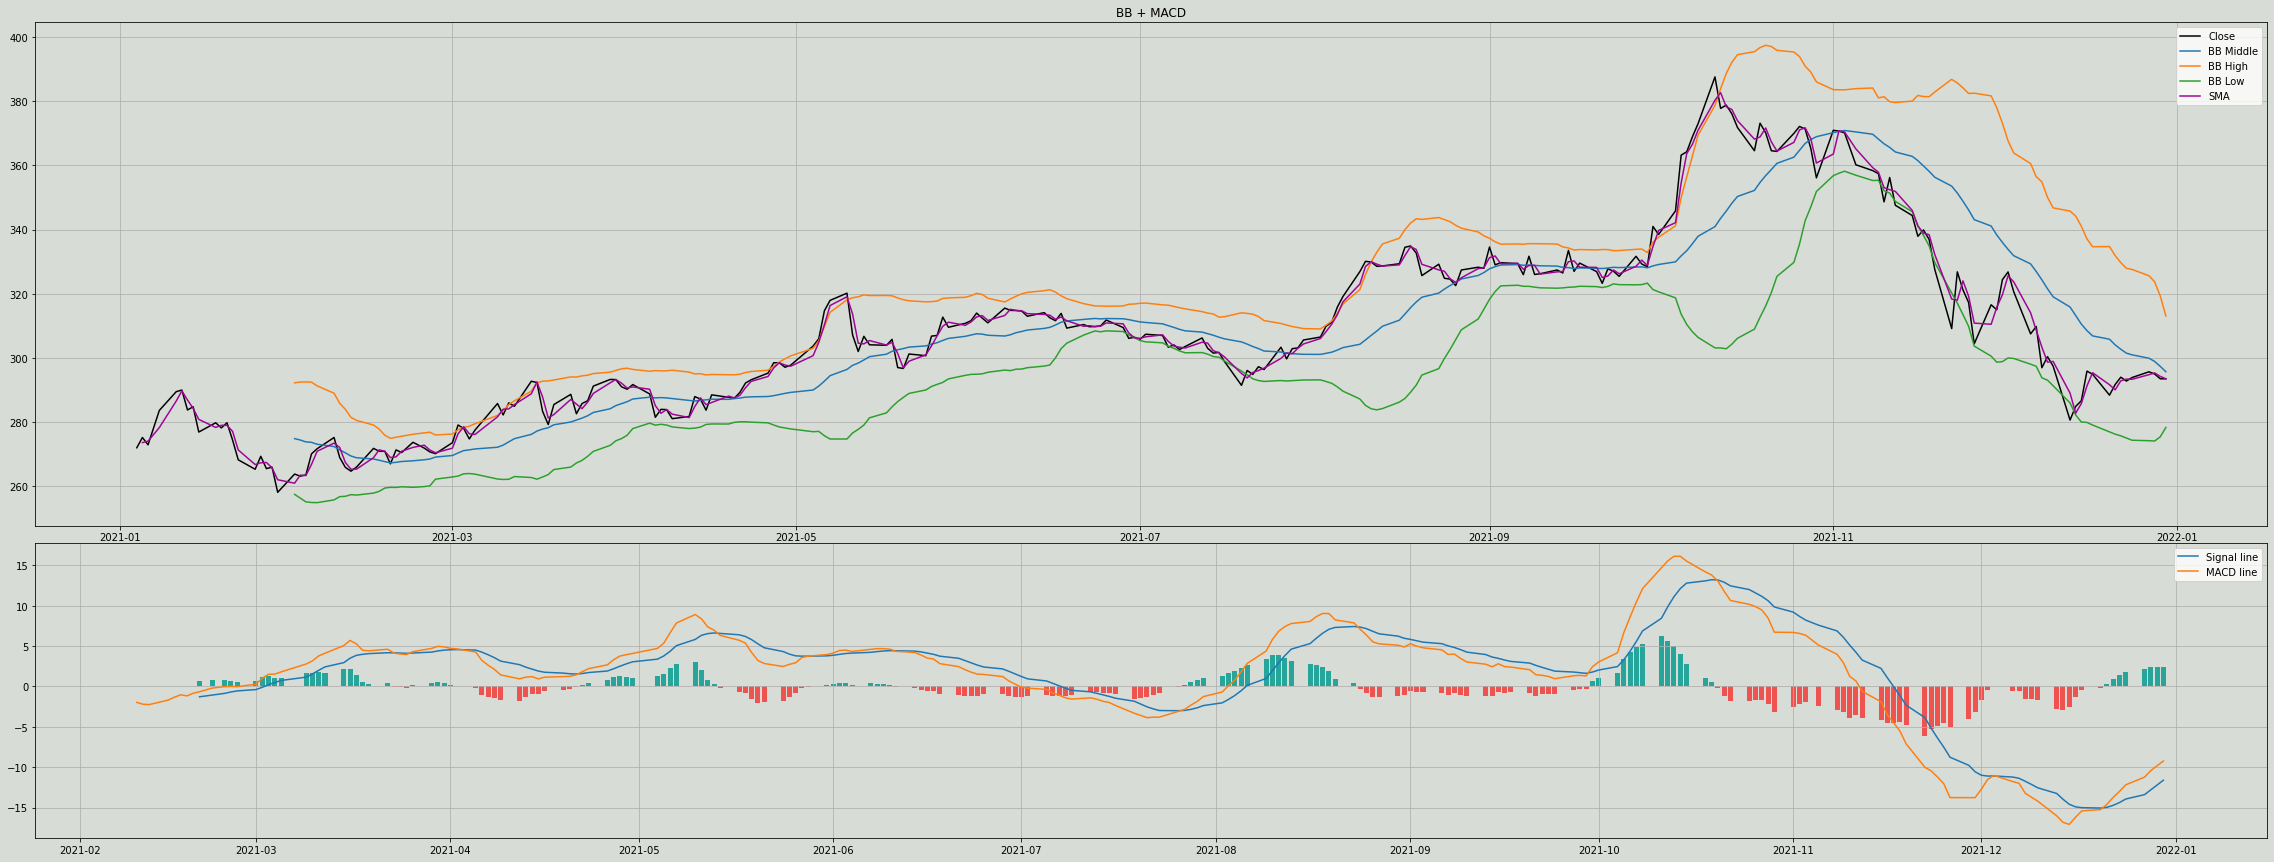

In [15]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax1.plot(df['<DATE>'],df['bb_bbm'], label = 'BB Middle')
ax1.plot(df['<DATE>'],df['bb_bbh'], label = 'BB High')
ax1.plot(df['<DATE>'],df['bb_bbl'], label = 'BB Low')
ax1.plot(df['<DATE>'],df['SMA'], label = 'SMA', color = '#a00498')

ax2.plot(df['<DATE>'],df['MACD_signal'], label = 'Signal line')
ax2.plot(df['<DATE>'],df['MACD'], label = 'MACD line')

for i in range(len(df)):
    if str(df['MACD_gist'][i])[0] == '-':
        ax2.bar(df['<DATE>'][i], df['MACD_gist'][i], color = '#ef5350',)
    else:
        ax2.bar(df['<DATE>'][i], df['MACD_gist'][i], color = '#26a69a')

ax1.set_title('BB + MACD')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('#d8dcd6')
ax2.set_facecolor('#d8dcd6')

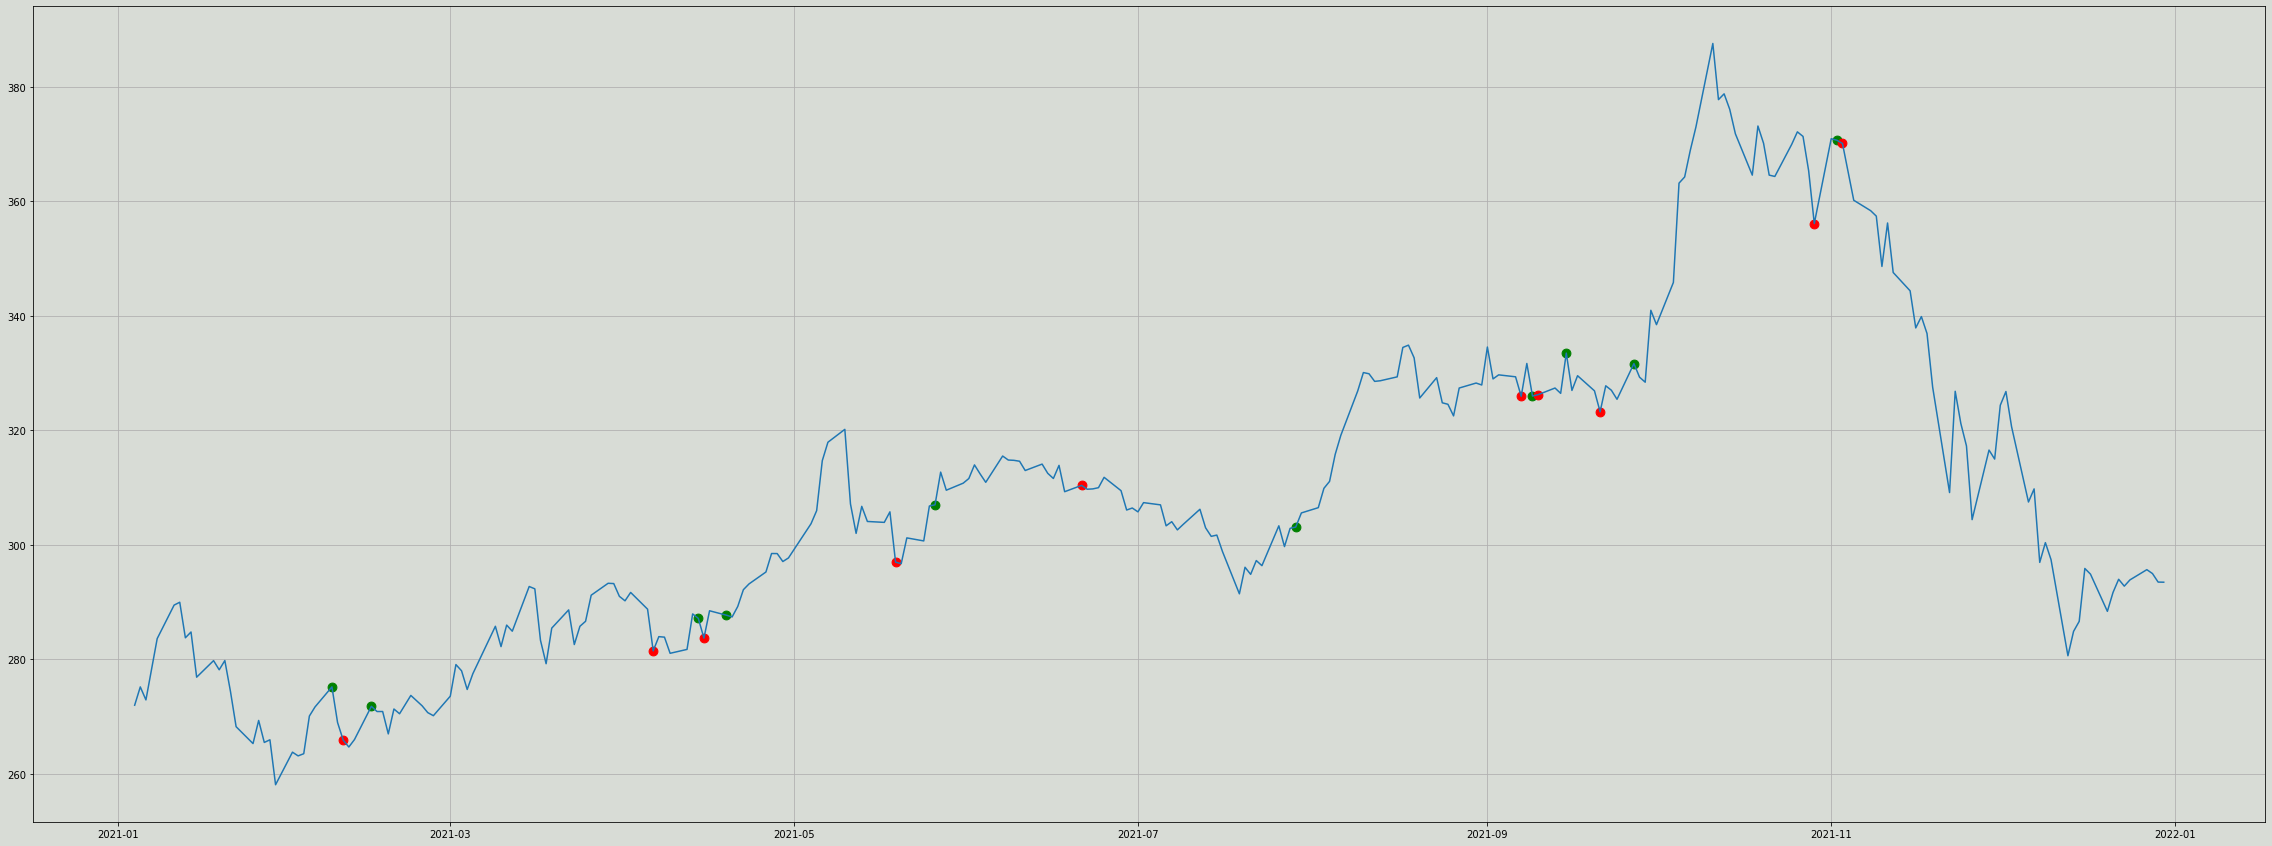

In [44]:
BBwithSMA = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
# k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in  range(len(df)):
  price = 0
  if ((balance >= df['<CLOSE>'][i]) and (df["SMA"][i] >= df["bb_bbm"][i]) and (df["SMA"][i-1] < df["bb_bbm"][i-1])): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["SMA"][i] <= df["bb_bbm"][i]) and (df["SMA"][i-1] > df["bb_bbm"][i-1]):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')
  
  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

BBwithSMA["NumOfShares"] = count_df
BBwithSMA["MoneySpent"] = price_df
BBwithSMA["Balance"] = balance_df
BBwithSMA["DayStatus"] = day_status

In [35]:
BBwithSMA[(BBwithSMA['DayStatus'] == 'buy') | (BBwithSMA['DayStatus'] == 'sell')]

,<DATE>,<CLOSE>,NumOfShares,MoneySpent,Balance,DayStatus
24,2021-02-08,275.20,363.0,99897.60,102.40,buy
26,2021-02-10,265.90,0.0,265.90,96624.10,sell
29,2021-02-15,271.81,355.0,96492.55,131.55,buy
64,2021-04-06,281.50,0.0,281.50,100064.05,sell
70,2021-04-14,287.18,348.0,99938.64,125.41,buy
71,2021-04-15,283.72,0.0,283.72,98859.97,sell
73,2021-04-19,287.72,343.0,98687.96,172.01,buy
94,2021-05-19,297.00,0.0,297.00,102043.01,sell
99,2021-05-26,307.01,332.0,101927.32,115.69,buy
117,2021-06-21,310.40,0.0,310.40,103168.49,sell


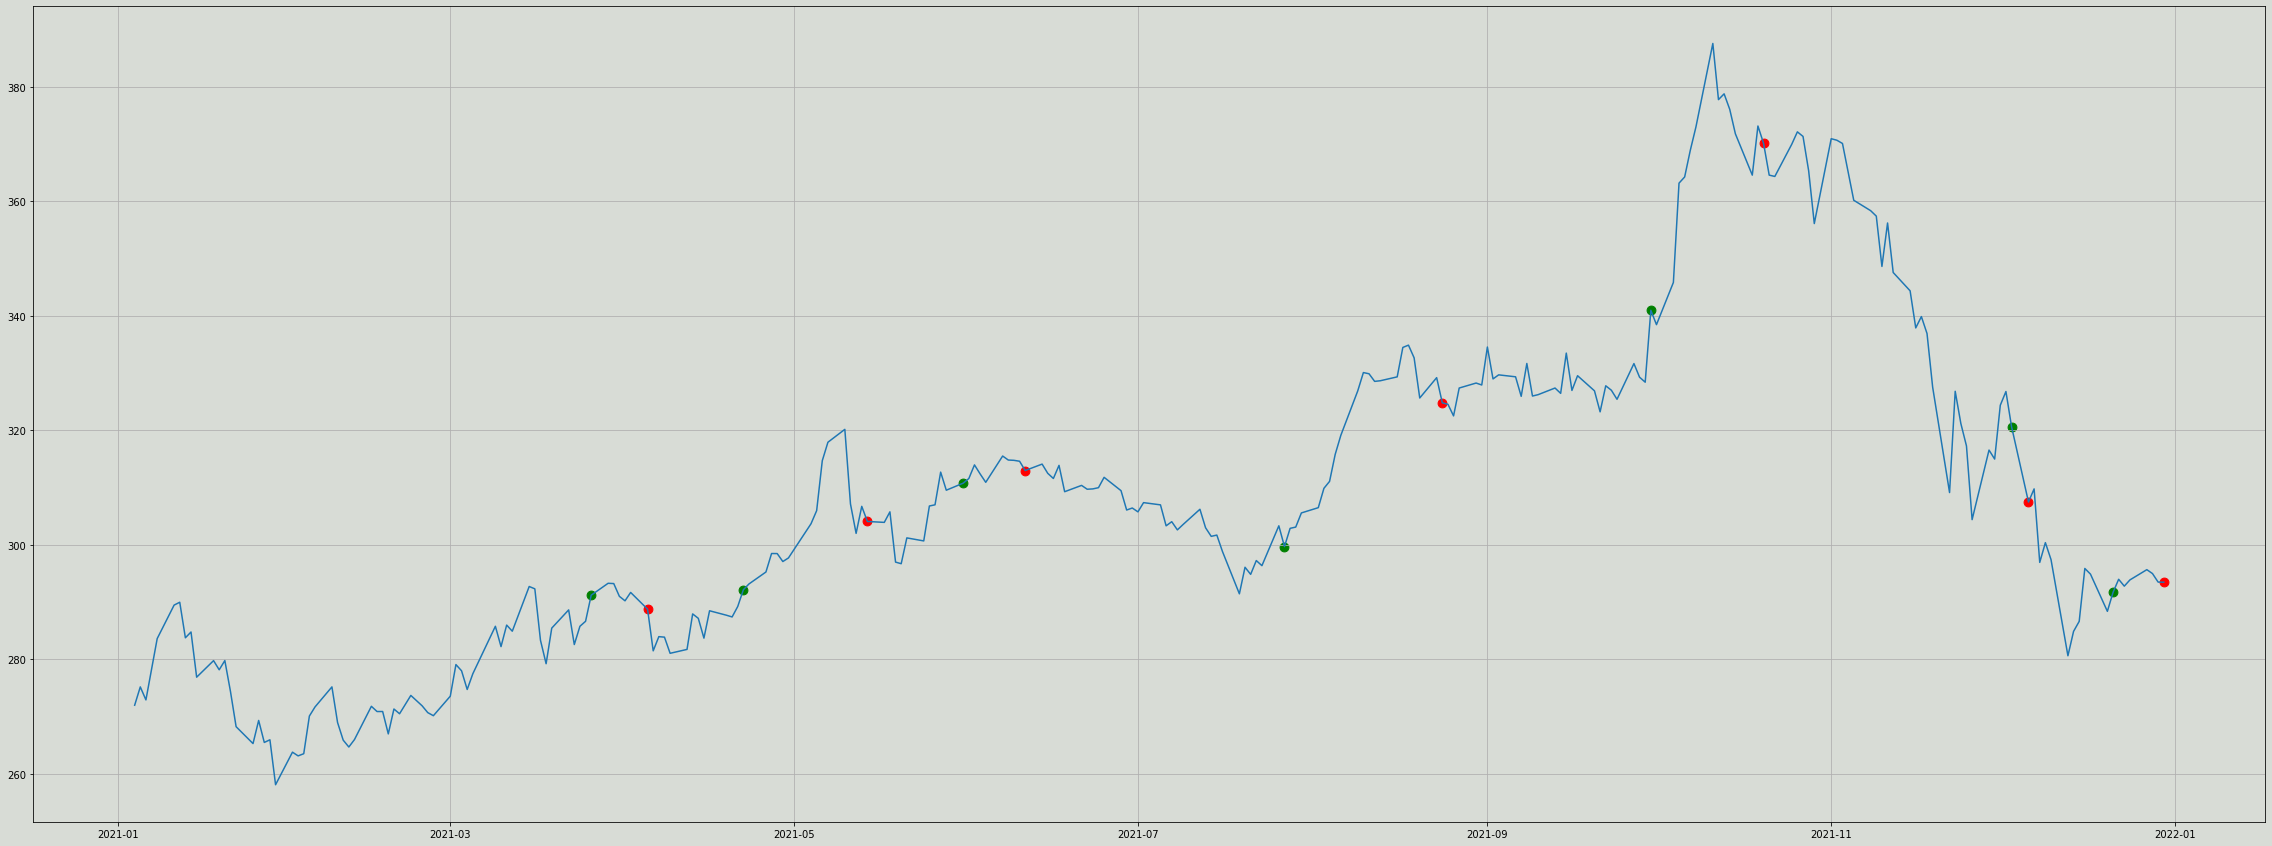

In [45]:
MACD = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
#k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in range(len(df)):
  if ((balance >= df['<CLOSE>'][i]) and (df["MACD"][i] >= df["MACD_signal"][i]) and (df["MACD"][i-1] < df["MACD_signal"][i-1])): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["MACD"][i] <= df["MACD_signal"][i]) and (df["MACD"][i-1] > df["MACD_signal"][i-1]):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')

  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

MACD["NumOfShares"] = count_df
MACD["MoneySpent"] = price_df
MACD["Balance"] = balance_df
MACD["DayStatus"] = day_status

In [33]:
MACD[(MACD['DayStatus'] == 'buy') | (MACD['DayStatus'] == 'sell')]

,<DATE>,<CLOSE>,NumOfShares,MoneySpent,Balance,DayStatus
57,2021-03-26,291.22,343.0,99888.46,111.54,buy
63,2021-04-05,288.78,0.0,288.78,99163.08,sell
76,2021-04-22,292.18,339.0,99049.02,114.06,buy
91,2021-05-14,304.10,0.0,304.10,103203.96,sell
102,2021-05-31,310.79,332.0,103182.28,21.68,buy
111,2021-06-11,313.00,0.0,313.00,103937.68,sell
143,2021-07-27,299.71,346.0,103699.66,238.02,buy
163,2021-08-24,324.83,0.0,324.83,112629.20,sell
190,2021-09-30,340.99,330.0,112526.70,102.50,buy
204,2021-10-20,370.16,0.0,370.16,122255.30,sell


# ATR + MA


In [20]:
# ATR
high_low = df['<HIGH>'] - df['<LOW>']
high_close = np.abs(df['<HIGH>'] - df['<CLOSE>'].shift())
low_close = np.abs(df['<CLOSE>'].shift() - df['<LOW>'])
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['ATR'] = true_range.rolling(14).sum()/14

In [21]:
df["SMAATR"] = SMAIndicator(close=df["ATR"], window = 14).sma_indicator()

In [22]:
from ta.trend import EMAIndicator
df['EMA'] = EMAIndicator(close = df['<CLOSE>'], window = 14).ema_indicator()

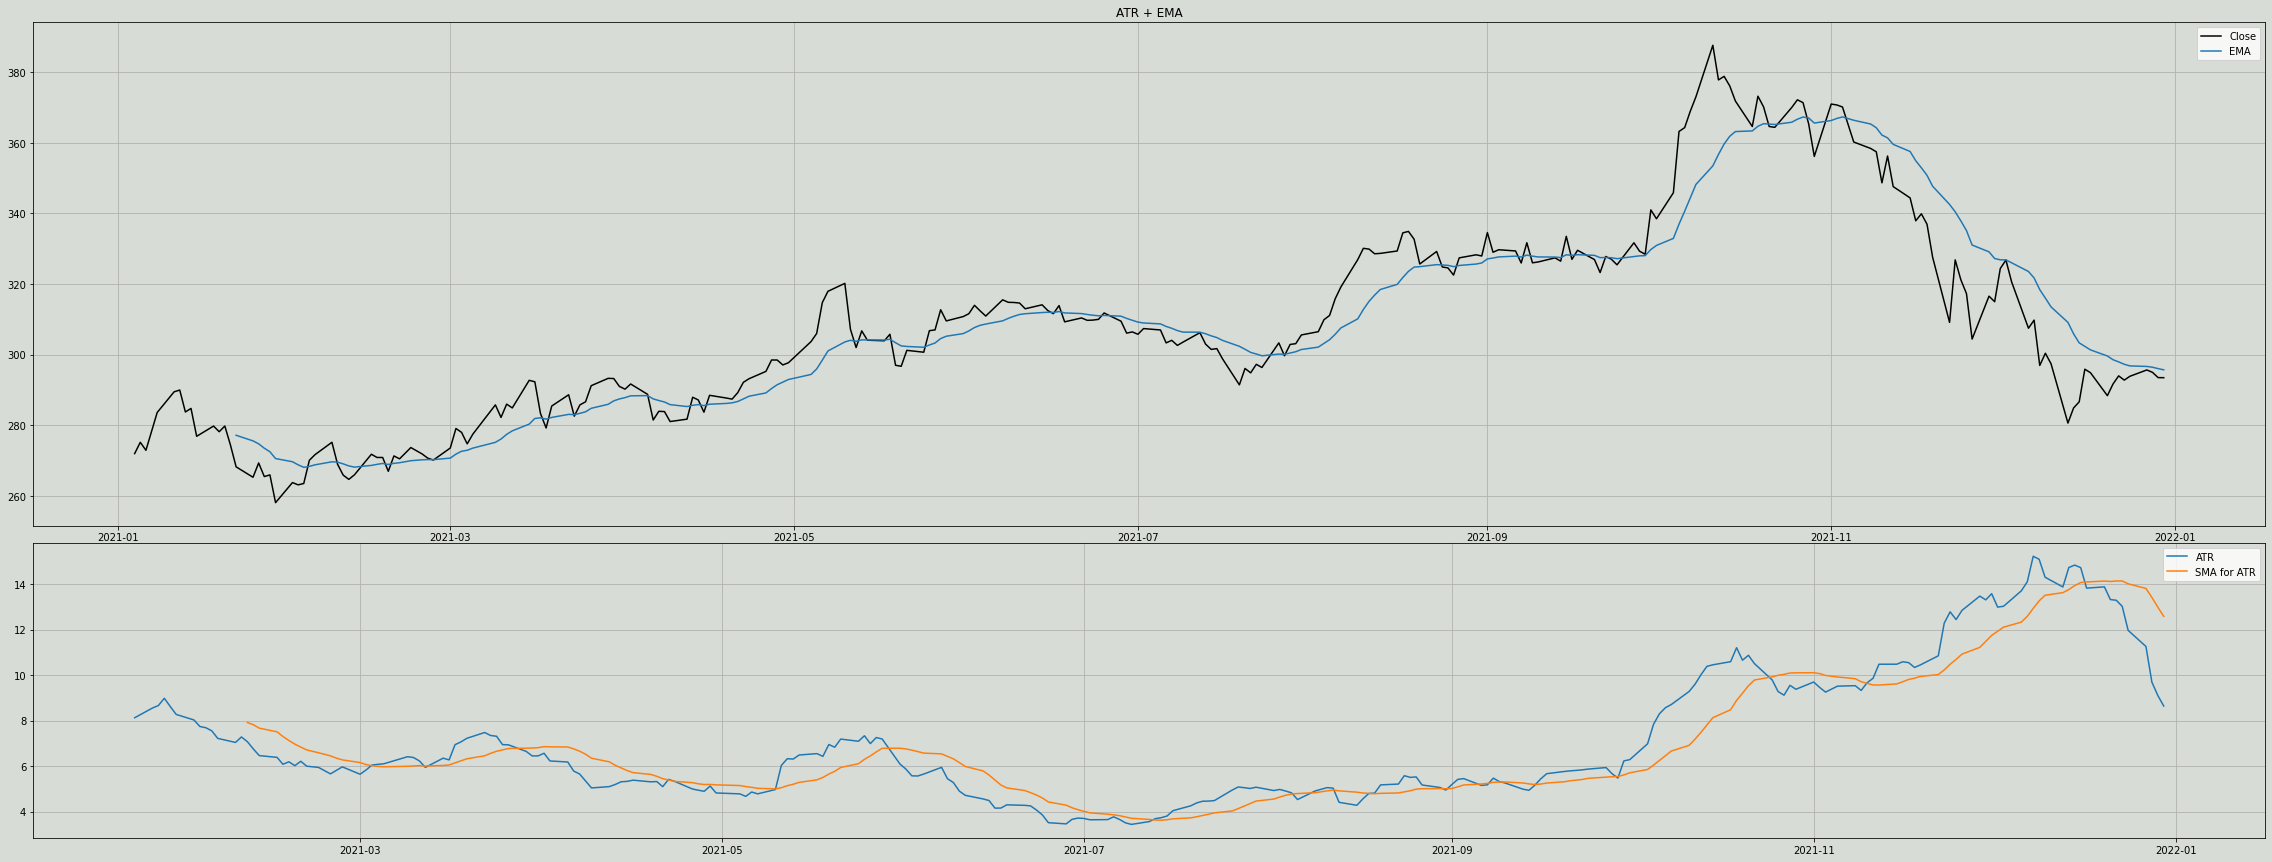

In [23]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')
ax1.plot(df['<DATE>'],df['EMA'], label = 'EMA')

ax2.plot(df['<DATE>'],df['ATR'], label = 'ATR')
ax2.plot(df['<DATE>'],df['SMAATR'], label = 'SMA for ATR')

ax1.set_title('ATR + EMA')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('#d8dcd6')
ax2.set_facecolor('#d8dcd6')

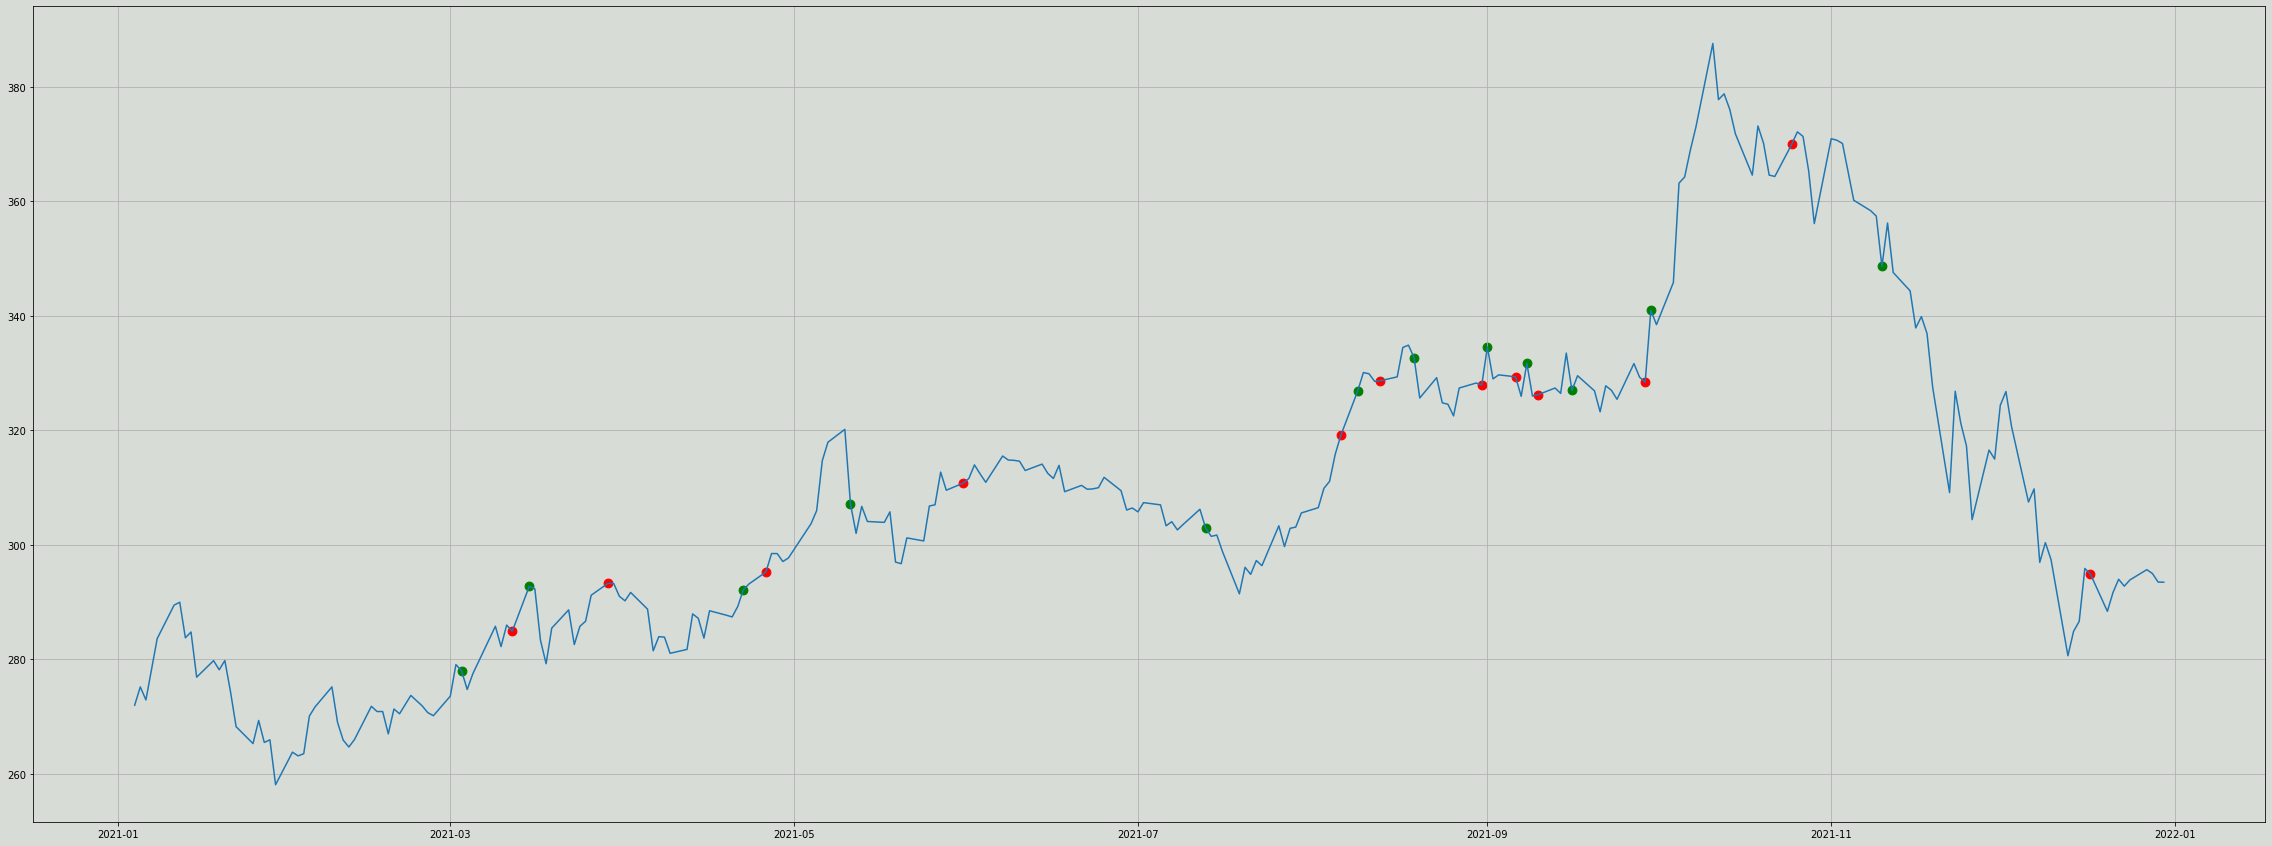

In [46]:
ATR = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
#k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in range(len(df)):
  if ((balance >= df['<CLOSE>'][i]) and (df["ATR"][i] >= df["SMAATR"][i]) and (df["ATR"][i-1] < df["SMAATR"][i-1])): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df["ATR"][i] <= df["SMAATR"][i]) and (df["ATR"][i-1] > df["SMAATR"][i-1]):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')

  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

ATR["NumOfShares"] = count_df
ATR["MoneySpent"] = price_df
ATR["Balance"] = balance_df
ATR["DayStatus"] = day_status

In [31]:
ATR[(ATR['DayStatus'] == 'buy') | (ATR['DayStatus'] == 'sell')]

,<DATE>,<CLOSE>,NumOfShares,MoneySpent,Balance,DayStatus
41,2021-03-03,278.01,359.0,99805.59,194.41,buy
47,2021-03-12,284.93,0.0,284.93,102484.28,sell
48,2021-03-15,292.74,350.0,102459.00,25.28,buy
58,2021-03-29,293.30,0.0,293.30,102680.28,sell
76,2021-04-22,292.18,351.0,102555.18,125.10,buy
78,2021-04-26,295.27,0.0,295.27,103764.87,sell
88,2021-05-11,307.16,337.0,103512.92,251.95,buy
102,2021-05-31,310.79,0.0,310.79,104988.18,sell
133,2021-07-13,303.00,346.0,104838.00,150.18,buy
151,2021-08-06,319.15,0.0,319.15,110576.08,sell


# AROON

In [26]:
def aroon(data, lb=25):
    df['AROONu'] = 100 * df['<HIGH>'].rolling(lb + 1).apply(lambda x: x.argmax()) / lb
    df['AROONd'] = 100 * df['<LOW>'].rolling(lb + 1).apply(lambda x: x.argmin()) / lb
aroon(df)

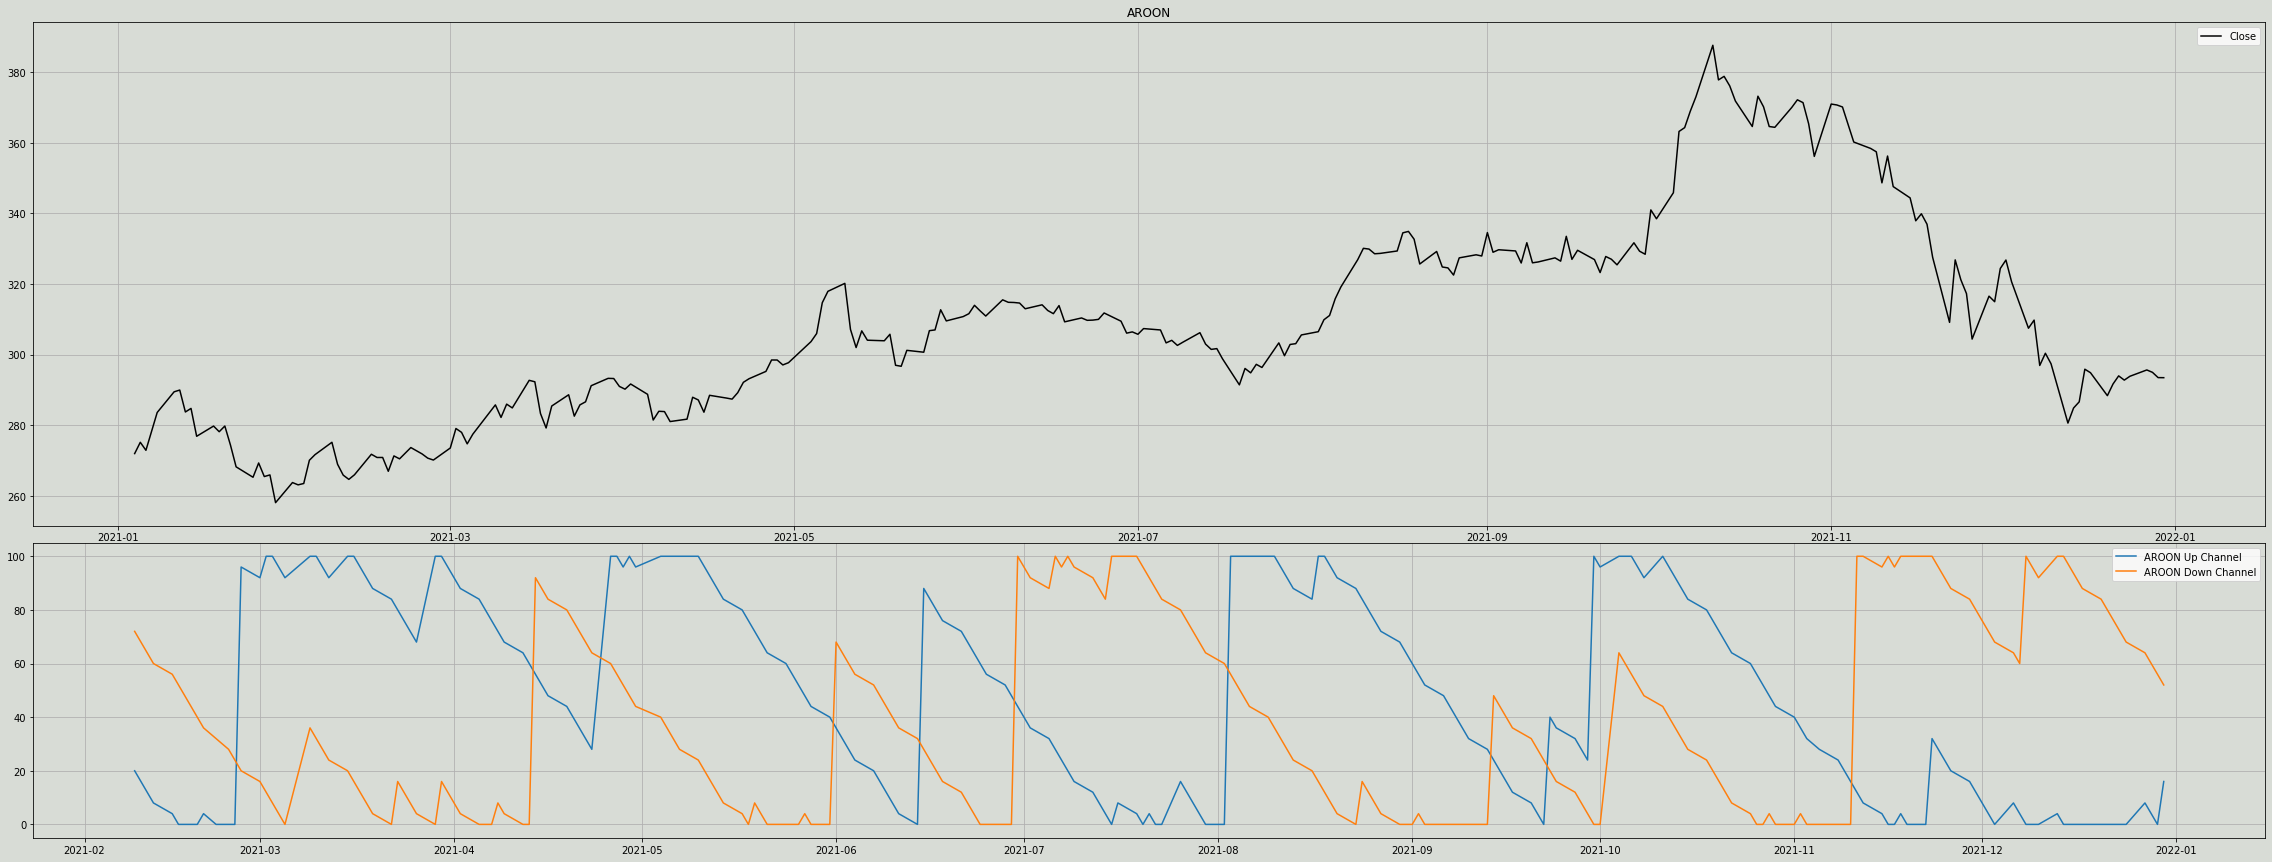

In [27]:
plt.figure(figsize = (40, 15), facecolor = '#d8dcd6')
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['<DATE>'],df['<CLOSE>'], label = 'Close', color = 'black')

ax2.plot(df['<DATE>'],df['AROONu'], label = 'AROON Up Channel')
ax2.plot(df['<DATE>'],df['AROONd'], label = 'AROON Down Channel')

ax1.set_title('AROON')
ax1.legend(loc = 'best')
ax2.legend(loc = 'best')

ax1.grid(True)
ax2.grid(True)

ax1.set_facecolor('#d8dcd6')
ax2.set_facecolor('#d8dcd6')

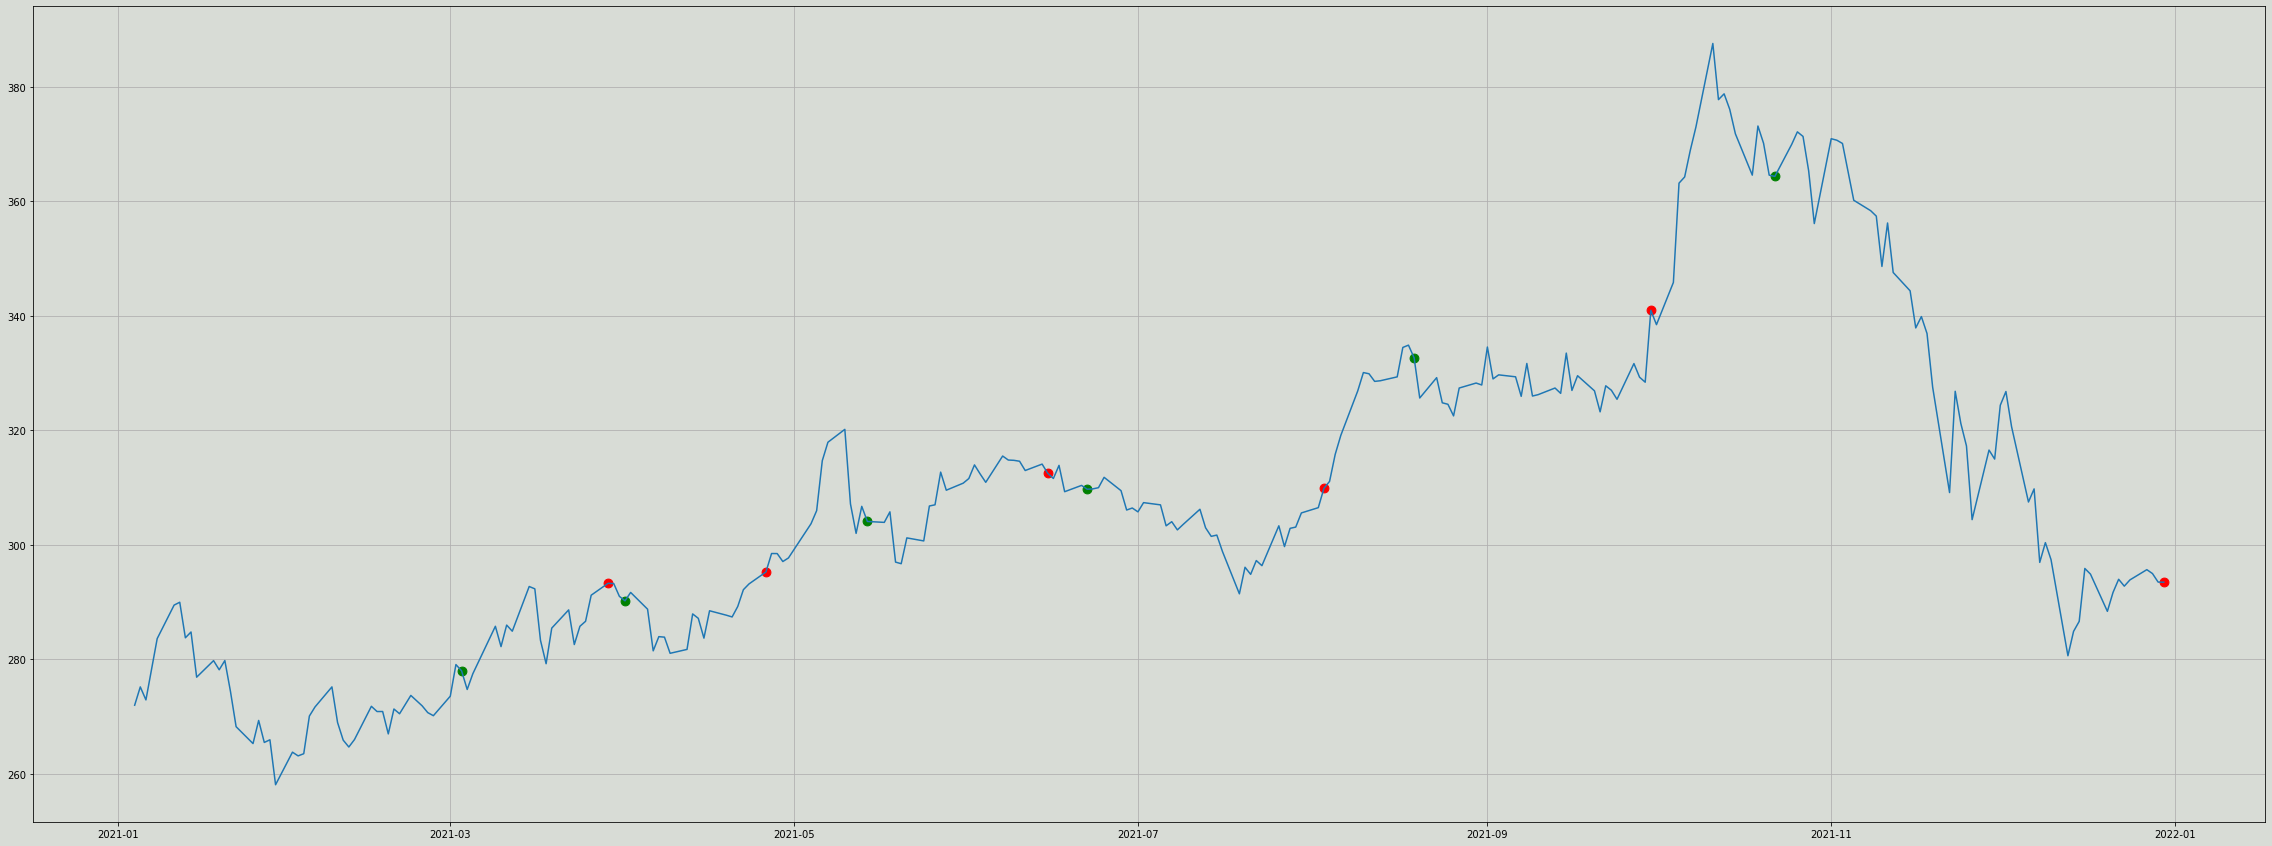

In [53]:
AROON = pd.DataFrame(df[['<DATE>', '<CLOSE>']])
balance = 100000
price = 0 
count = 0
#k = 0
balance_df, count_df, price_df, day_status = [], [], [], []
fig,ax=plt.subplots(facecolor="#d8dcd6",figsize=(40,15))
plt.plot(df['<DATE>'],df["<CLOSE>"])

for i in range(len(df)):
  if (balance >= df['<CLOSE>'][i]) and (df['AROONd'][i] <= 10) and (df['AROONd'][i-1] > 10): 
    count += balance // df['<CLOSE>'][i]
    price = df['<CLOSE>'][i] * count
    balance = balance - price
    #k += price * 0.01
    day_status.append('buy')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='green', s=78)
  
  elif count > 0 and (df['AROONu'][i] >= 70) and (df['AROONu'][i-1] < 70):
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)

  elif i == (len(df)-1) and count>0:
    balance += count * df['<CLOSE>'][i]
    #k += count * df['<CLOSE>'][i] * 0.01
    count = 0
    price = df['<CLOSE>'][i]
    day_status.append('sell')
    #print(f'Комиссия за всё время: {k}')
    #balance -= k
    plt.scatter(df['<DATE>'][i] , df['<CLOSE>'][i], c='red', s=78)
  else:
    day_status.append('nothing')

  count_df.append(count)
  balance_df.append(balance)
  price_df.append(price)

ax.set_facecolor('#d8dcd6')
ax.grid(True)

AROON["NumOfShares"] = count_df
AROON["MoneySpent"] = price_df
AROON["Balance"] = balance_df
AROON["DayStatus"] = day_status

In [54]:
AROON[(AROON['DayStatus'] == 'buy') | (AROON['DayStatus'] == 'sell')]

,<DATE>,<CLOSE>,NumOfShares,MoneySpent,Balance,DayStatus
41,2021-03-03,278.01,359.0,99805.59,194.41,buy
58,2021-03-29,293.30,0.0,293.30,105489.11,sell
61,2021-04-01,290.24,363.0,105357.12,131.99,buy
78,2021-04-26,295.27,0.0,295.27,107315.00,sell
91,2021-05-14,304.10,352.0,107043.20,271.80,buy
113,2021-06-15,312.51,0.0,312.51,110275.32,sell
118,2021-06-22,309.73,356.0,110263.88,11.44,buy
148,2021-08-03,309.89,0.0,309.89,110332.28,sell
160,2021-08-19,332.69,331.0,110120.39,211.89,buy
190,2021-09-30,340.99,0.0,340.99,113079.58,sell
